In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image

In [7]:
# Định nghĩa các biến siêu tham số
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [8]:
# Bước tiền xử lý hình ảnh
transform = transforms.Compose([
    transforms.ToTensor(),          # Chuyển ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ảnh
])

# Tạo dataset từ thư mục
data_dir = '/home/bird_Image'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

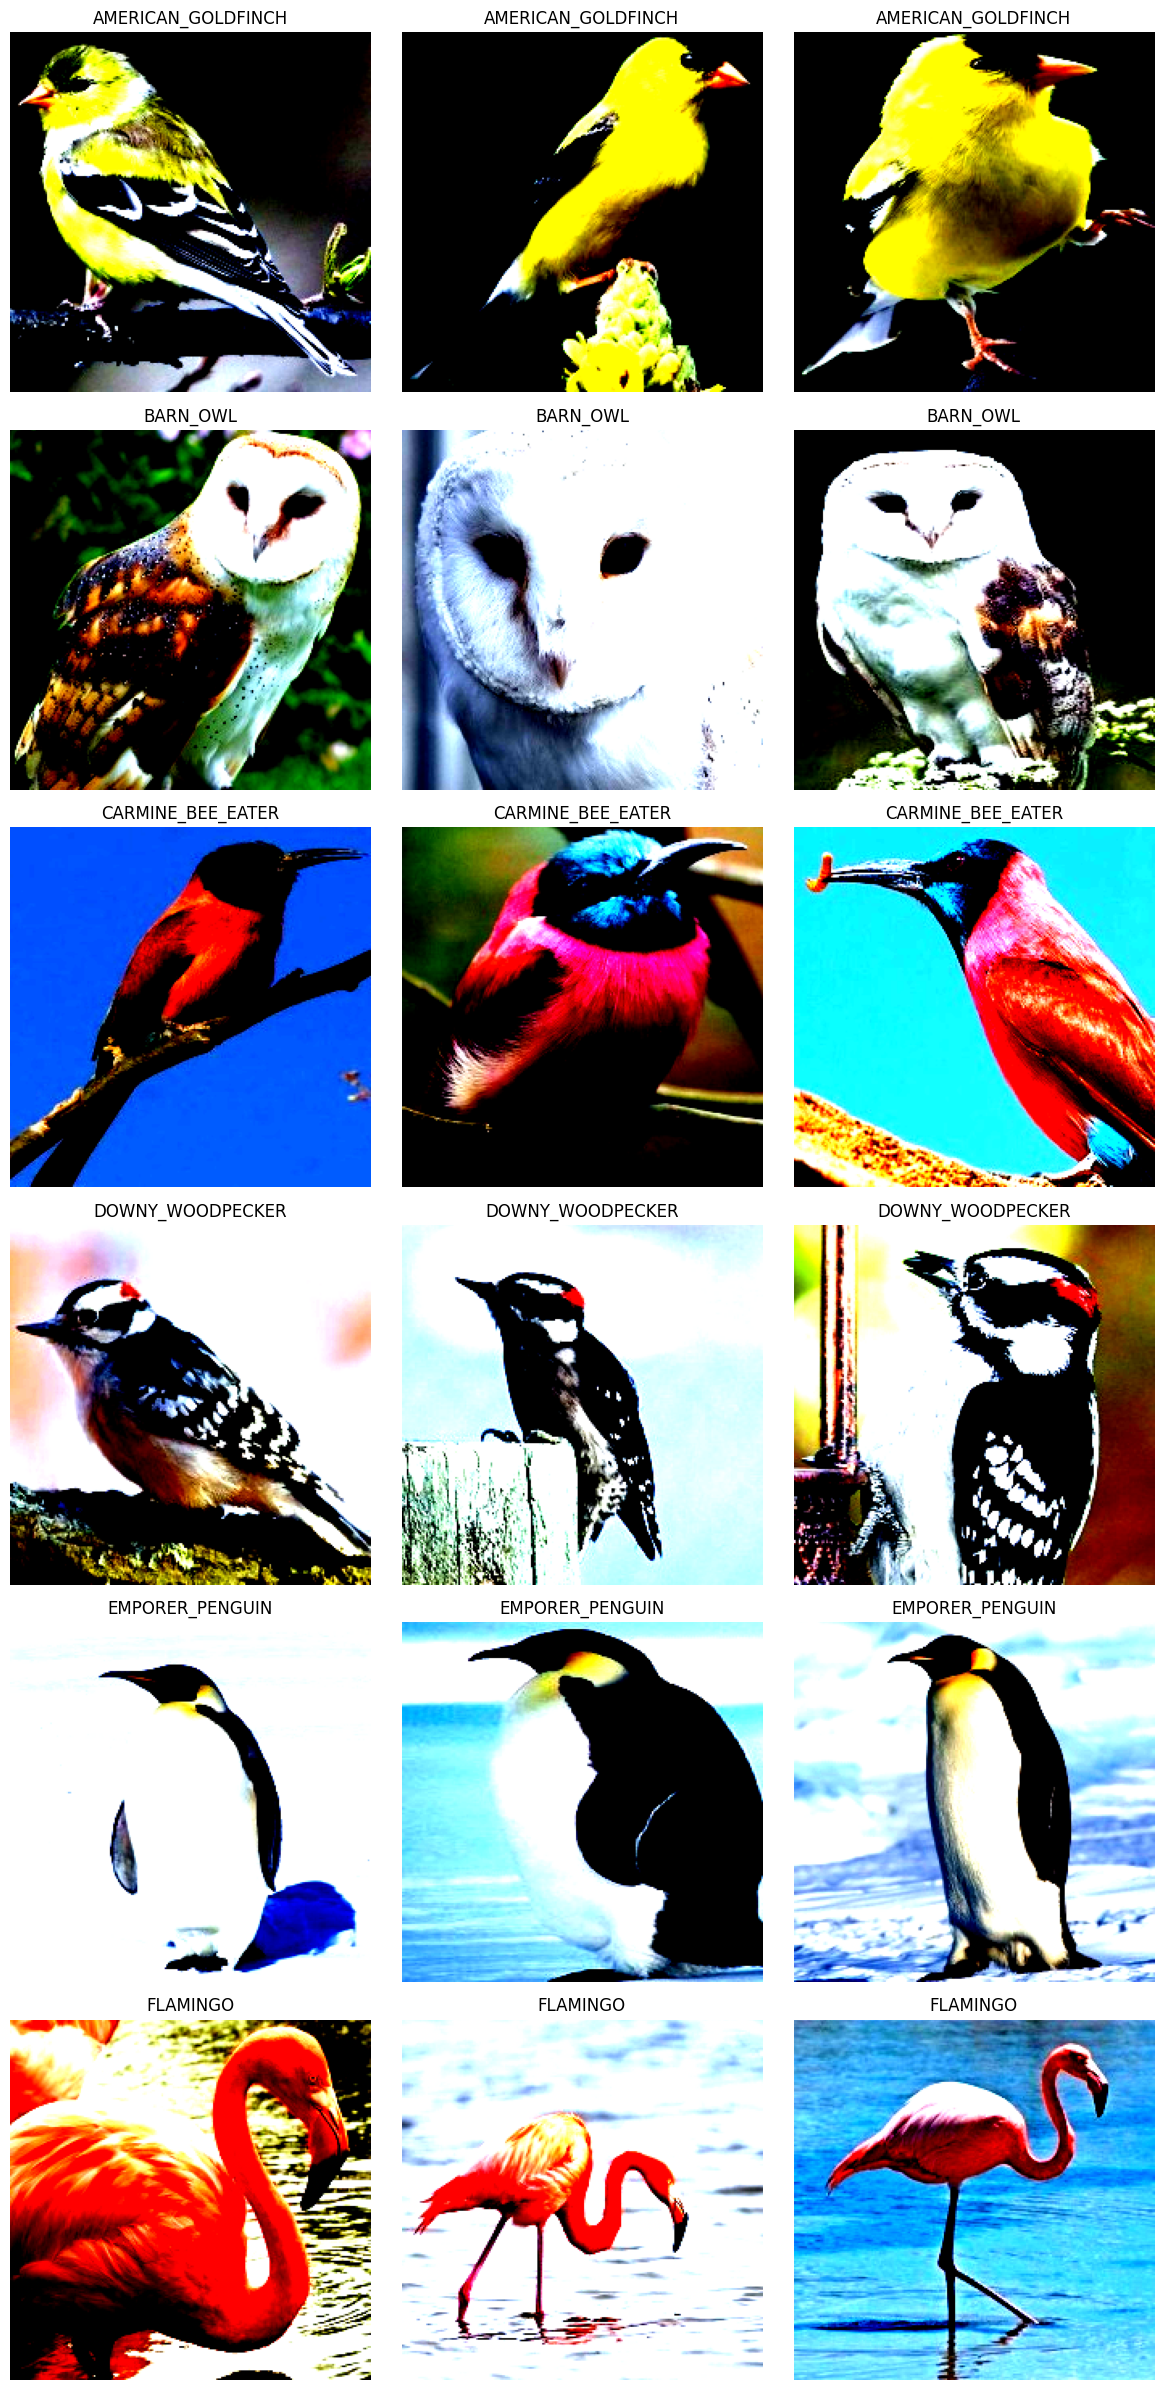

In [9]:
images_per_row = 3
num_classes = len(dataset.classes)

fig, axes = plt.subplots(num_classes, images_per_row, figsize=(12, num_classes*4))

if num_classes == 1:
    axes = np.expand_dims(axes, 0)

for class_idx, class_name in enumerate(dataset.classes):
    class_images = [img for img, label in dataset if label == class_idx]
    
    for i, img in enumerate(class_images[:images_per_row]):
        ax = axes[class_idx, i]
        ax.imshow(img.permute(1, 2, 0))  
        ax.set_title(class_name)
        ax.axis('off')  

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset

labels = [label for _, label in dataset]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(range(len(dataset)), labels):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

# Tạo DataLoader cho tập huấn luyện và kiểm tra
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Kiểm tra phân bố lớp trong các tập
train_labels = [label for _, label in train_subset]
test_labels = [label for _, label in test_subset]

# Đếm số lượng ảnh trong mỗi lớp của tập huấn luyện và kiểm tra
train_label_count = torch.bincount(torch.tensor(train_labels))
test_label_count = torch.bincount(torch.tensor(test_labels))

# In ra số lượng ảnh theo từng lớp
print("Số lượng ảnh trong từng lớp (train dataset):")
for idx, count in enumerate(train_label_count):
    print(f"Lớp {dataset.classes[idx]}: {count.item()} ảnh")

print("\nSố lượng ảnh trong từng lớp (test dataset):")
for idx, count in enumerate(test_label_count):
    print(f"Lớp {dataset.classes[idx]}: {count.item()} ảnh")

Số lượng ảnh trong từng lớp (train dataset):
Lớp AMERICAN_GOLDFINCH: 114 ảnh
Lớp BARN_OWL: 103 ảnh
Lớp CARMINE_BEE_EATER: 105 ảnh
Lớp DOWNY_WOODPECKER: 109 ảnh
Lớp EMPORER_PENGUIN: 111 ảnh
Lớp FLAMINGO: 106 ảnh

Số lượng ảnh trong từng lớp (test dataset):
Lớp AMERICAN_GOLDFINCH: 29 ảnh
Lớp BARN_OWL: 26 ảnh
Lớp CARMINE_BEE_EATER: 26 ảnh
Lớp DOWNY_WOODPECKER: 28 ảnh
Lớp EMPORER_PENGUIN: 28 ảnh
Lớp FLAMINGO: 26 ảnh


In [11]:
class_names = dataset.classes
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, len(class_names))  # Số lớp đầu ra là 6 (loài chim)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()


Epoch [1/10], Loss: 4.0132
Epoch [2/10], Loss: 1.1734
Epoch [3/10], Loss: 0.4986
Epoch [4/10], Loss: 0.2440
Epoch [5/10], Loss: 0.1313
Epoch [6/10], Loss: 0.0822
Epoch [7/10], Loss: 0.0207
Epoch [8/10], Loss: 0.0087
Epoch [9/10], Loss: 0.0053
Epoch [10/10], Loss: 0.0036
Training complete!


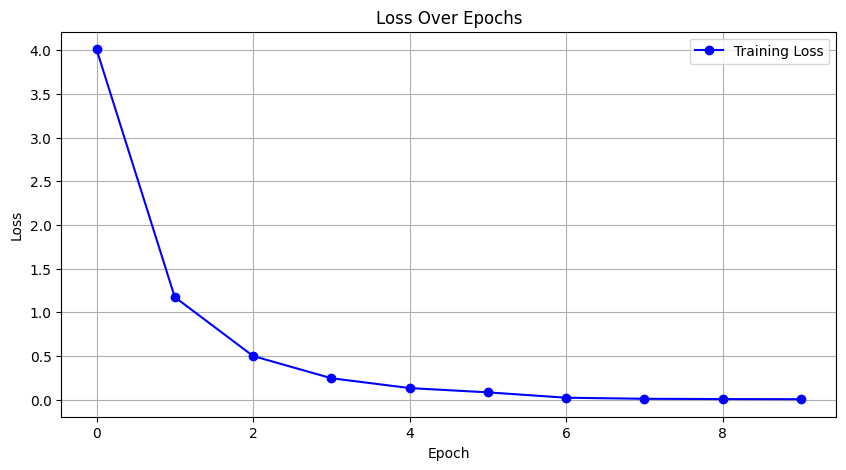

In [12]:
# Cài đặt loss function và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []

# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    # Bước 1: Dự đoán trên toàn bộ tập kiểm tra
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Bước 2: Tính toán độ chính xác tổng thể
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    
    # Bước 3: Tạo báo cáo chi tiết các chỉ số cho từng lớp
    report = classification_report(
        all_labels, 
        all_predictions, 
        target_names=['AMERICAN_GOLDFINCH', 'BARN_OWL', 
                      'CARMINE_BEE_EATER', 'DOWNY_WOODPECKER', 
                      'EMPORER_PENGUIN', 'FLAMINGO']
    )

    # Bước 4: In kết quả ra màn hình
    print("="*40)
    print(f"Test Accuracy: {accuracy:.2f}%")
    print("="*40)
    print("Classification Report:")
    print(report)
    print("="*40)
    
    # Tùy chọn: Trả về kết quả nếu cần dùng ở nơi khác
    return accuracy, report

# Gọi hàm để đánh giá mô hình
accuracy, report = evaluate_model(model, test_loader)

Test Accuracy: 87.12%
Classification Report:
                    precision    recall  f1-score   support

AMERICAN_GOLDFINCH       0.88      1.00      0.94        29
          BARN_OWL       0.73      0.85      0.79        26
 CARMINE_BEE_EATER       0.88      0.88      0.88        26
  DOWNY_WOODPECKER       0.96      0.82      0.88        28
   EMPORER_PENGUIN       0.90      0.96      0.93        28
          FLAMINGO       0.90      0.69      0.78        26

          accuracy                           0.87       163
         macro avg       0.88      0.87      0.87       163
      weighted avg       0.88      0.87      0.87       163



In [27]:
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = transform1(img).unsqueeze(0)  # Thêm batch dimension
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]

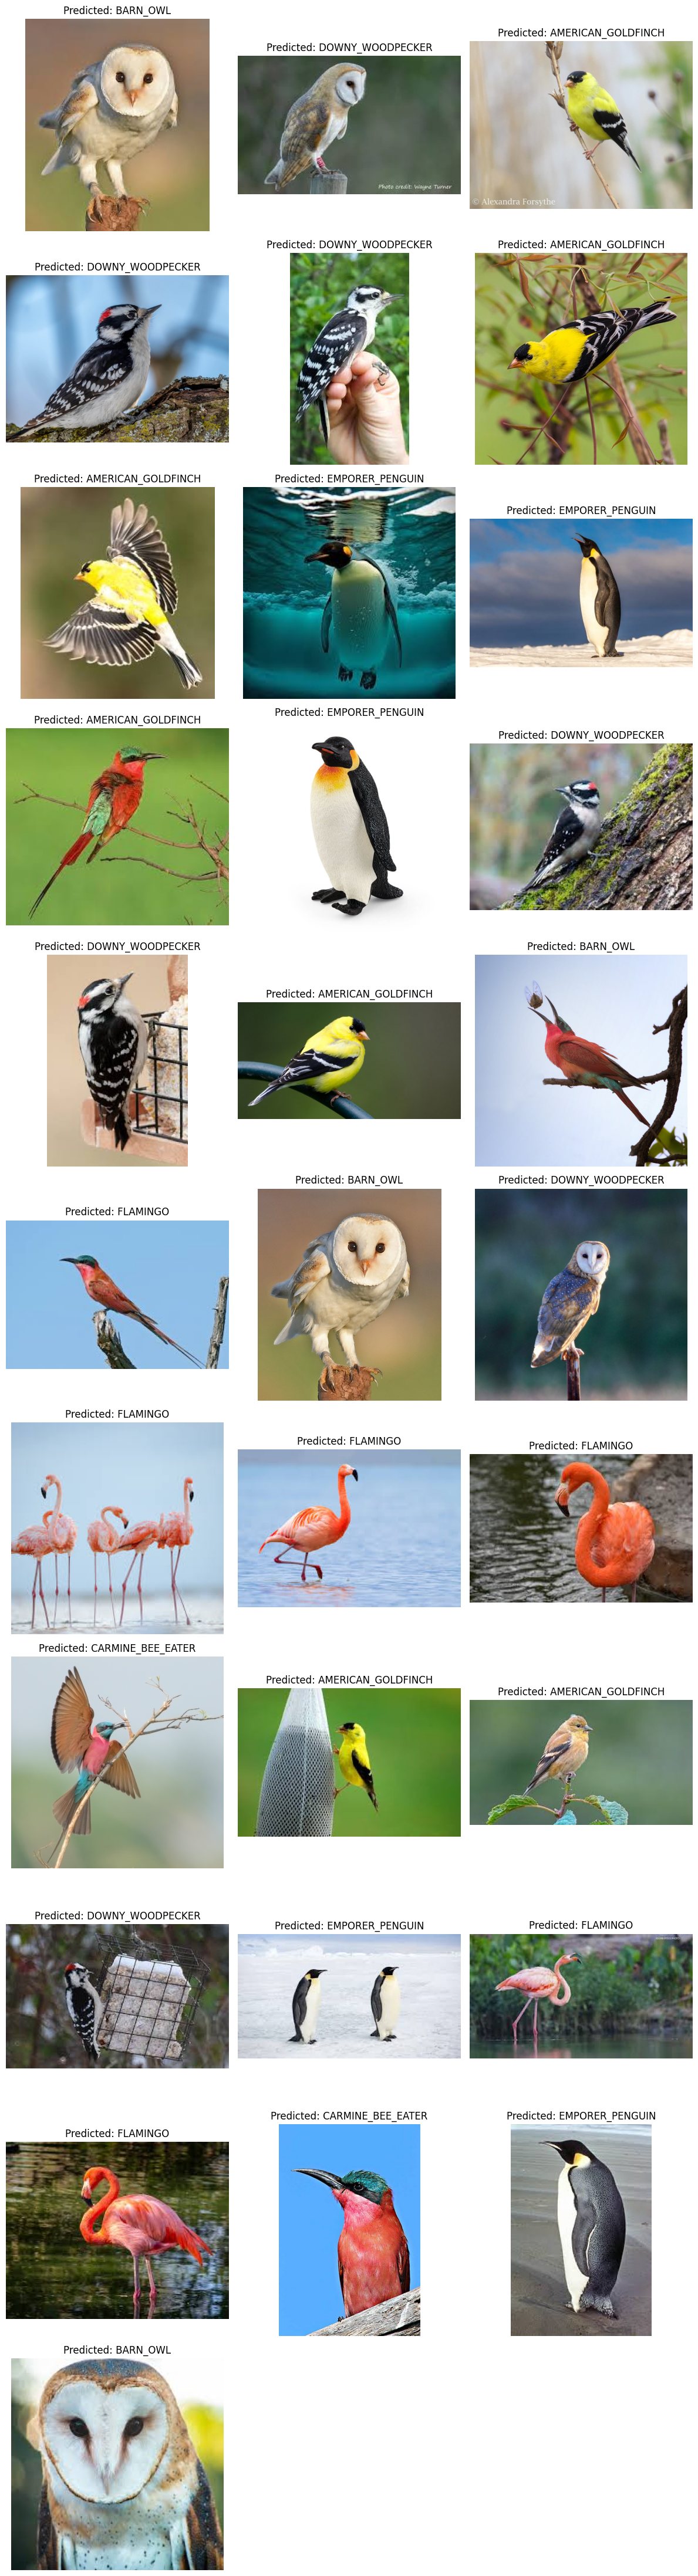

In [ ]:
image_paths = []
predictions = []
folder_path = '/home/eval_bird'
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Kiểm tra nếu là hình ảnh
        image_path = os.path.join(folder_path, filename)
        prediction = predict_image(image_path, model)
        
        # Thêm đường dẫn hình ảnh và dự đoán vào danh sách
        image_paths.append(image_path)
        predictions.append(prediction)

# Số lượng hình ảnh mỗi hàng
images_per_row = 3
num_images = len(image_paths)

# Tạo số hàng cần thiết
num_rows = (num_images + images_per_row - 1) // images_per_row  # Làm tròn lên số hàng cần thiết

# Tạo một figure với kích thước phù hợp
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(12, 4 * num_rows))

# Nếu chỉ có 1 hàng, axes sẽ là một mảng 1D
if num_rows == 1:
    axes = axes.reshape(1, images_per_row)

# Hiển thị từng hình ảnh
for i, ax in enumerate(axes.flat):
    if i < num_images:
        img = Image.open(image_paths[i])
        ax.imshow(img)
        ax.set_title(f"Predicted: {predictions[i]}")
    ax.axis('off')  # Ẩn trục

# Hiển thị tất cả các hình ảnh
plt.tight_layout()
plt.show()

In [34]:
torch.save(model.state_dict(), 'bird_classification_model.pth')
print("Model saved successfully!")

Model saved successfully!
